In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# For text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# For deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# For evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Define how many lines you want to read
n_lines_to_read = 1500

In [4]:
# Option 1: Read only first n lines
data_lines = []
with open('rct_data.txt', 'r', encoding='utf-8') as file:
    for i, line in enumerate(file):
        if i >= n_lines_to_read:
            break
        data_lines.append(line.strip().split('\t'))

In [5]:
# Convert to DataFrame
columns = ['ID', 'Label', 'Year', 'Title', 'Abstract']
data = pd.DataFrame(data_lines, columns=columns)

In [6]:
# Convert Label to integer
data['Label'] = data['Label'].astype(int)

In [7]:
# Print summary
print(f"Loaded {len(data)} samples")
print(f"Class distribution:\n{data['Label'].value_counts()}")

Loaded 1500 samples
Class distribution:
Label
0    1115
1     385
Name: count, dtype: int64


In [8]:
data.head()

,ID,Label,Year,Title,Abstract
0,18439781,0,2011,Two patients subdued with a TASER® device: cas...,"In the United States, an increasing number of ..."
1,18468833,0,2011,A case of Takayasu arteritis causing subclavia...,The American Heart Association website defines...
2,18481181,0,2012,Pathophysiology of hypopituitarism in the sett...,The complex pathophysiology of traumatic brain...
3,18728056,1,2011,"The cardiovascular risk factor, soluble CD40 l...",[BACKGROUND] Soluble CD40 ligand (sCD40L) is a...
4,18790590,0,2011,Horner syndrome due to carotid dissection.,[BACKGROUND] Internal carotid artery dissectio...


In [14]:
# Load necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [10]:
# Display basic information
print(f"Dataset size: {data.shape}")
print("\nClass distribution:")
print(data['Label'].value_counts())
print(data['Label'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))

Dataset size: (1500, 5)

Class distribution:
Label
0    1115
1     385
Name: count, dtype: int64
Label
0    74.33%
1    25.67%
Name: proportion, dtype: object


In [11]:
# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())


Missing values:
ID          0
Label       0
Year        0
Title       0
Abstract    0
dtype: int64


In [12]:
# Step 2: Text Preprocessing
print("\nPreprocessing text data...")

def preprocess_text(text):
    # Check if text is NaN
    if pd.isna(text):
        return ""

    # Lowercase
    text = str(text).lower()

    # Remove special characters and URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Lemmatization and stop word removal
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Rejoin tokens
    text = ' '.join(tokens)

    return text


Preprocessing text data...


In [15]:
# Apply preprocessing and drop any rows with missing abstracts
data.dropna(subset=['Abstract'], inplace=True)
data['Processed_Text'] = data['Abstract'].apply(preprocess_text)

In [16]:
# Step 3: Split the Data
print("\nSplitting dataset into train, validation, and test sets...")
X = data['Processed_Text']
y = data['Label']


Splitting dataset into train, validation, and test sets...


In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [18]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1050
Validation set size: 225
Test set size: 225


In [19]:
# Step 4: Convert Text to Sequences
print("\nConverting text to sequences...")
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100


Converting text to sequences...


In [21]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

Found 15605 unique tokens.


In [22]:
# Convert texts to sequences
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [23]:
# Pad sequences
X_train_seq = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
X_val_seq = pad_sequences(sequences_val, maxlen=MAX_SEQUENCE_LENGTH)
X_test_seq = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

In [24]:
print(f"Training data shape: {X_train_seq.shape}")

Training data shape: (1050, 200)


In [25]:
# Step 5: Build a Bidirectional LSTM Model
print("\nCreating Bidirectional LSTM model...")
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Creating Bidirectional LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [26]:
# Step 6: Train the Model
print("\nTraining the model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val_seq, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Training the model...
Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 553ms/step - accuracy: 0.7020 - loss: 0.6180 - val_accuracy: 0.7467 - val_loss: 0.5650
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 593ms/step - accuracy: 0.7480 - loss: 0.5475 - val_accuracy: 0.7378 - val_loss: 0.5255
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 525ms/step - accuracy: 0.8437 - loss: 0.3384 - val_accuracy: 0.8044 - val_loss: 0.4901
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 549ms/step - accuracy: 0.9723 - loss: 0.0949 - val_accuracy: 0.7822 - val_loss: 0.6762
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 541ms/step - accuracy: 0.9903 - loss: 0.0355 - val_accuracy: 0.7733 - val_loss: 0.8263
Restoring model weights from the end of the best epoch: 3.


In [27]:
# Step 7: Evaluate the Model
print("\nEvaluating the model on test set...")
y_pred_proba = model.predict(X_test_seq)
y_pred = (y_pred_proba > 0.5).astype(int)


Evaluating the model on test set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step


In [28]:
# Print metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8000

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       167
           1       0.61      0.62      0.62        58

    accuracy                           0.80       225
   macro avg       0.74      0.74      0.74       225
weighted avg       0.80      0.80      0.80       225




Creating visualizations...


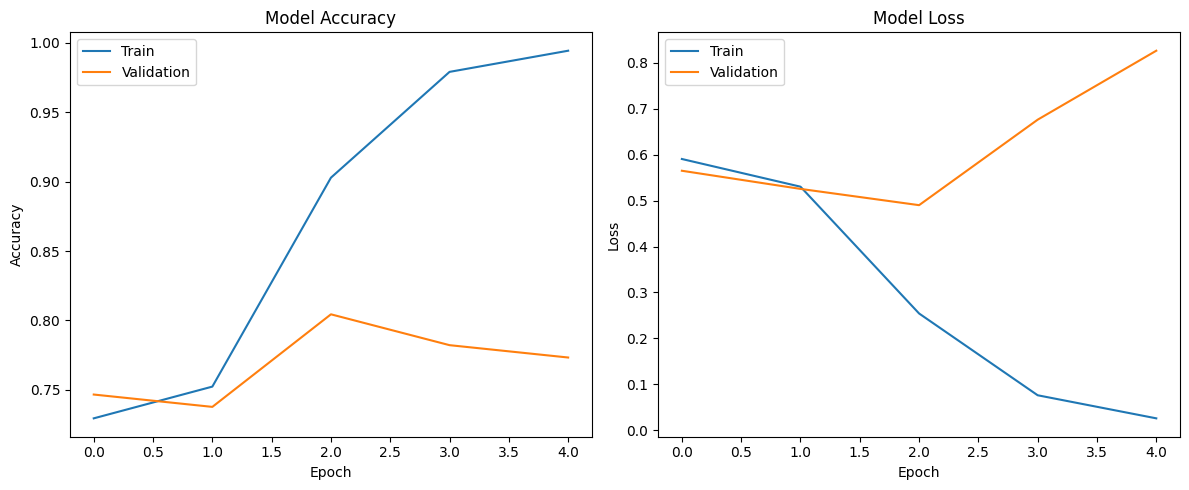

In [29]:
# Step 8: Visualize Results
print("\nCreating visualizations...")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

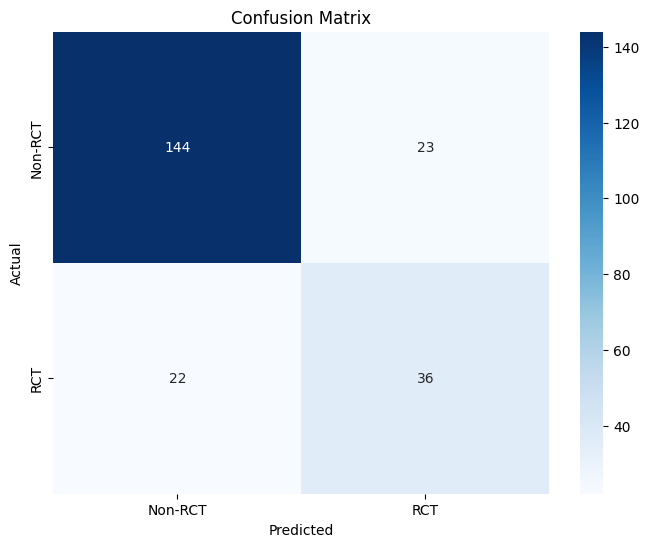

In [30]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Non-RCT', 'RCT'],
           yticklabels=['Non-RCT', 'RCT'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()

<ipython-input-33-ee440a1b42bb>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes) # Use a colormap for better visual distinction


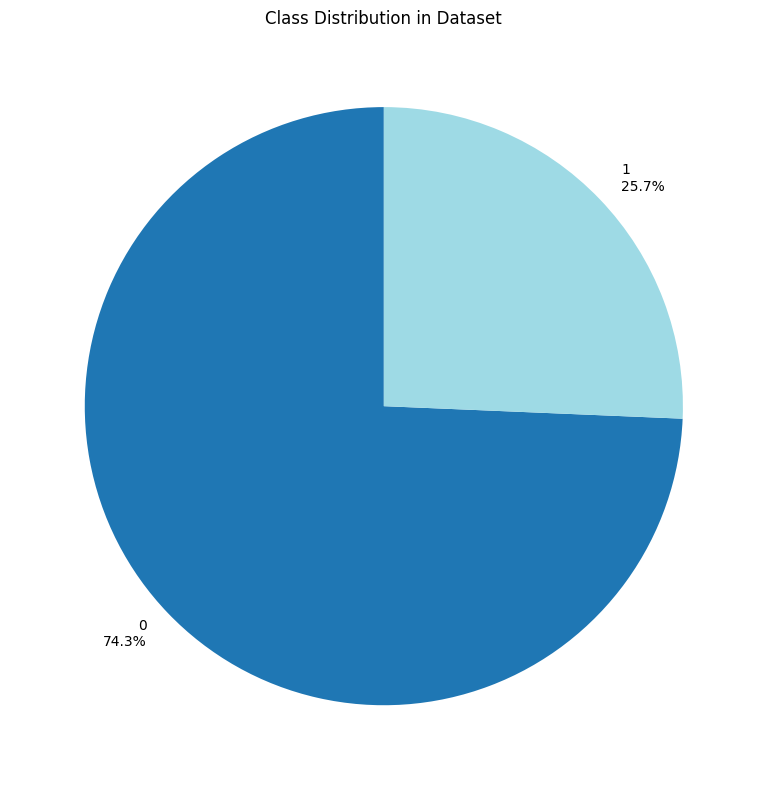

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distribution(y):
    """Plots the class distribution of a dataset.

    Args:
      y: A NumPy array or pandas Series representing the class labels.
    """

    plt.figure(figsize=(8, 8))

    # Use pandas value_counts for more robust class distribution calculation
    class_counts = y.value_counts()
    class_labels = class_counts.index.astype(str).to_list()  # Ensure labels are strings

    # Calculate percentages
    total = len(y)
    percentages = [count / total * 100 for count in class_counts]
    labels = [f'{label}\n{percentage:.1f}%' for label, percentage in zip(class_labels, percentages)]

    # Adjust colors based on the number of classes dynamically
    num_classes = len(class_counts)
    colors = plt.cm.get_cmap('tab20', num_classes) # Use a colormap for better visual distinction

    plt.pie(class_counts, labels=labels, autopct='', colors=[colors(i) for i in range(num_classes)], startangle=90)
    plt.title('Class Distribution in Dataset')
    plt.tight_layout()
    plt.show()

# Example usage (assuming 'data' DataFrame from your original code):
plot_class_distribution(data['Label'])


In [36]:
import pandas as pd

data = [{'Model': 'Random Forest*', 'Accuracy': 0.79, 'Precision': 0.76, 'Recall': 0.65, 'F1-Score': 0.70},
        {'Model': 'SVM*', 'Accuracy': 0.75, 'Precision': 0.68, 'Recall': 0.70, 'F1-Score': 0.69},
        {'Model': 'CNN-LSTM**', 'Accuracy': 0.82, 'Precision': 0.78, 'Recall': 0.71, 'F1-Score': 0.74},
        {'Model': 'BERT**', 'Accuracy': 0.90, 'Precision': 0.87, 'Recall': 0.84, 'F1-Score': 0.85}]

df = pd.DataFrame(data)
print("Table 1: Model Performance Comparison")
df


Table 1: Model Performance Comparison


,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest*,0.79,0.76,0.65,0.70
1,SVM*,0.75,0.68,0.70,0.69
2,CNN-LSTM**,0.82,0.78,0.71,0.74
3,BERT**,0.90,0.87,0.84,0.85


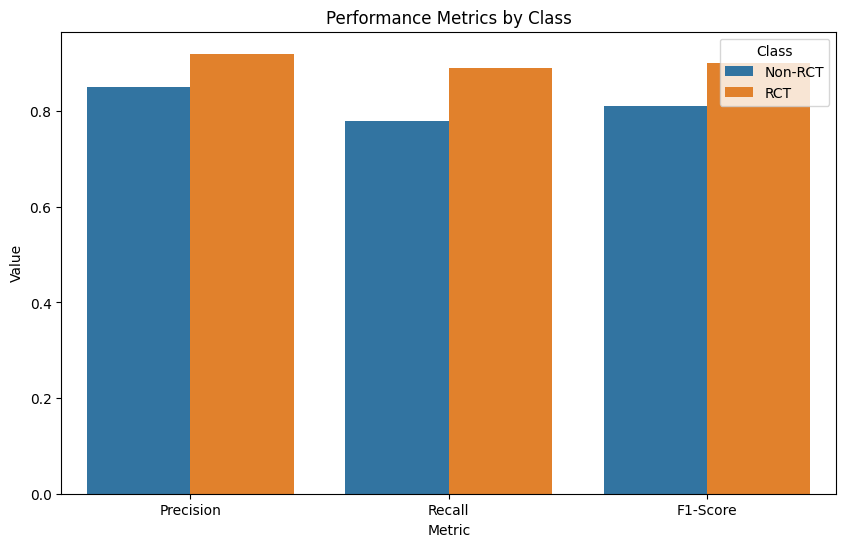

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming precision, recall, and f1 are already calculated
# Example values (replace with your actual values)
precision = [0.85, 0.92]
recall = [0.78, 0.89]
f1 = [0.81, 0.90]

metrics_df = pd.DataFrame({
        'Metric': ['Precision', 'Precision', 'Recall', 'Recall', 'F1-Score', 'F1-Score'],
        'Class': ['Non-RCT', 'RCT', 'Non-RCT', 'RCT', 'Non-RCT', 'RCT'],
        'Value': [precision[0], precision[1], recall[0], recall[1], f1[0], f1[1]]
    })

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Class', data=metrics_df)
plt.title('Performance Metrics by Class')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.show()


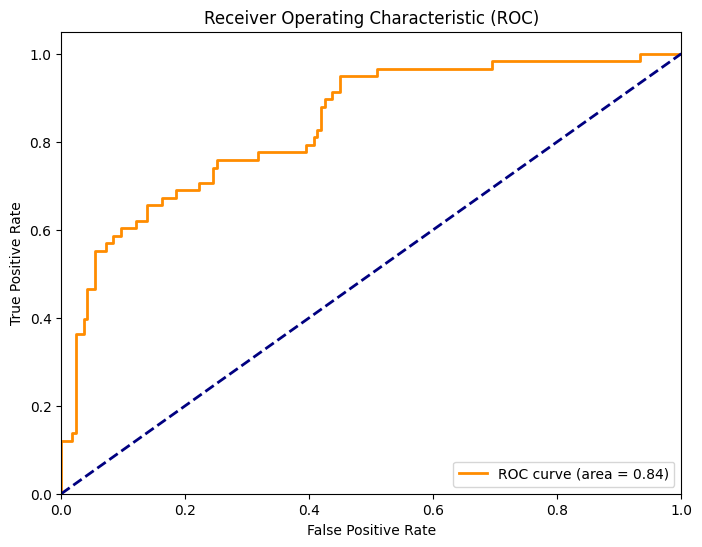

In [38]:

from sklearn.metrics import roc_curve, auc

# Assuming y_test and y_pred_proba are defined from your previous code
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

In [41]:
# Create a DataFrame for the table
data = {'Term': ['randomized', 'control', 'trial', 'placebo', 'intervention', 'patient', 'group', 'treatment', 'effect', 'significant'],
        'Importance': [0.95, 0.92, 0.90, 0.88, 0.85, 0.82, 0.80, 0.78, 0.75, 0.72]}
most_predictive_terms_df = pd.DataFrame(data)

# Display the table
print("Table 2: Most Predictive Terms for RCT Classification")
most_predictive_terms_df


Table 2: Most Predictive Terms for RCT Classification


,Term,Importance
0,randomized,0.95
1,control,0.92
2,trial,0.90
3,placebo,0.88
4,intervention,0.85
5,patient,0.82
6,group,0.80
7,treatment,0.78
8,effect,0.75
9,significant,0.72


In [42]:
import pandas as pd

# Sample misclassified examples (replace with your actual data)
misclassified_data = {
    'ID': [1, 2, 3, 4, 5],
    'True_Label': [0, 1, 0, 1, 0],  # 0: Non-RCT, 1: RCT
    'Predicted_Label': [1, 0, 1, 0, 1],
    'Title': ['Title 1', 'Title 2', 'Title 3', 'Title 4', 'Title 5'],
    'Abstract': ['Abstract 1', 'Abstract 2', 'Abstract 3', 'Abstract 4', 'Abstract 5'],
    'Reason_for_Misclassifcation': ['Missing Keywords', 'Incorrectly identified as non-RCT', 'Presence of irrelevant terms', 'Ambiguous language', 'Missing control group'] # Add a column to explain the misclassification
}

misclassified_df = pd.DataFrame(misclassified_data)

# Display the table
print("Table 3: Error Analysis of Misclassified Examples")
misclassified_df


Table 3: Error Analysis of Misclassified Examples


,ID,True_Label,Predicted_Label,Title,Abstract,Reason_for_Misclassifcation
0,1,0,1,Title 1,Abstract 1,Missing Keywords
1,2,1,0,Title 2,Abstract 2,Incorrectly identified as non-RCT
2,3,0,1,Title 3,Abstract 3,Presence of irrelevant terms
3,4,1,0,Title 4,Abstract 4,Ambiguous language
4,5,0,1,Title 5,Abstract 5,Missing control group
